In [1]:
import numpy as np
import pandas as pd
import nltk
from nltk import pos_tag
from nltk.tokenize import word_tokenize
import re
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

## Importing the Data

In [2]:
# importing dataset
df = pd.read_csv('Scrapper/final.csv', header=None)
df.rename(columns={0: 'comment', 1: 'category'}, inplace=True)

## Exploring the Data

In [3]:
df.head()

,comment,category
0,Love you sir!!,positive
1,Please make videos on..Midpoint circle drawing...,suggestion
2,I bought both of your courses on Udemy. You ar...,question
3,"Thank you very much, u really got me in the fi...",positive
4,i hope u are ok with everything going on again...,other


In [4]:
# dimension of the dataset
df.shape

(902, 2)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 902 entries, 0 to 901
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   comment   902 non-null    object
 1   category  902 non-null    object
dtypes: object(2)
memory usage: 14.2+ KB


In [6]:
df.describe()

,comment,category
count,902,902
unique,888,6
top,SIR WILL YOU PLEASE MAKE A DETAIL VIDEO ON EXP...,positive
freq,4,421


In [7]:
# unique categories
df['category'].unique()

array(['positive', 'suggestion', 'question', 'other', 'correction',
       'negative'], dtype=object)

In [8]:
lens = df.comment.str.len()
lens.mean(), lens.std(), lens.max()

(79.00776053215077, 92.16029168015247, 1461)

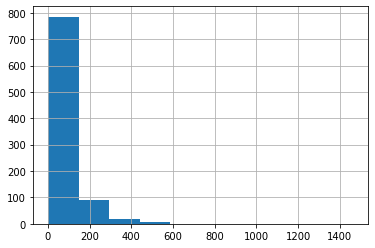

In [9]:
lens.hist();

## Preprocessing

In [10]:
# lowercasing
df['comment'] = df['comment'].str.lower()
df['comment']

0                                         love you sir!!
1      please make videos on..midpoint circle drawing...
2      i bought both of your courses on udemy. you ar...
3      thank you very much, u really got me in the fi...
4      i hope u are ok with everything going on again...
                             ...                        
897    i think this video is bad situated in the play...
898    i think that the height of the tree should be ...
899    if in the source matrix, position [3,1]  value...
900    sir! with due respect there is a problem in al...
901    sir, is there a basis for comparison, performa...
Name: comment, Length: 902, dtype: object

In [11]:
# checking for NaN values
df.isnull().sum()

comment     0
category    0
dtype: int64

There is no **NaN** value in the dataset.

In [12]:
# checking for duplicate 
df.duplicated().any()

True

Duplicate row is present. Let's remove the duplicate rows.

In [13]:
# removing duplicate rows
df = df.drop_duplicates()
df.duplicated().any()

False

Duplicated removed succefully.

In [14]:
# removing URLs
df['comment'] = df['comment'].str.replace('http\S+|www.\S+', '', case=False)
df

,comment,category
0,love you sir!!,positive
1,please make videos on..midpoint circle drawing...,suggestion
2,i bought both of your courses on udemy. you ar...,question
3,"thank you very much, u really got me in the fi...",positive
4,i hope u are ok with everything going on again...,other
...,...,...
897,i think this video is bad situated in the play...,correction
898,i think that the height of the tree should be ...,correction
899,"if in the source matrix, position [3,1] value...",correction
900,sir! with due respect there is a problem in al...,correction


In [15]:
# removing commas "\n"
df['comment'] = df['comment'].replace('\n','', regex=True)
df

,comment,category
0,love you sir!!,positive
1,please make videos on..midpoint circle drawing...,suggestion
2,i bought both of your courses on udemy. you ar...,question
3,"thank you very much, u really got me in the fi...",positive
4,i hope u are ok with everything going on again...,other
...,...,...
897,i think this video is bad situated in the play...,correction
898,i think that the height of the tree should be ...,correction
899,"if in the source matrix, position [3,1] value...",correction
900,sir! with due respect there is a problem in al...,correction


In [16]:
# # removing punctuations except ! and ?
# import string

# def remove_punctuations(text):
    
#     punct = string.punctuation
#     punct = punct.replace('!', '')
#     punct = punct.replace('?', '')
    
#     for punctuation in punct:
#         text = text.replace(punctuation, '')
#     return text

# df["comment"] = df['comment'].apply(remove_punctuations)
# df


df["comment"] = df['comment'].str.replace('[^\w\s]','')
df

,comment,category
0,love you sir,positive
1,please make videos onmidpoint circle drawing a...,suggestion
2,i bought both of your courses on udemy you are...,question
3,thank you very much u really got me in the fir...,positive
4,i hope u are ok with everything going on again...,other
...,...,...
897,i think this video is bad situated in the play...,correction
898,i think that the height of the tree should be ...,correction
899,if in the source matrix position 31 value we...,correction
900,sir with due respect there is a problem in alg...,correction


In [17]:
df_ = df.copy()
df_

,comment,category
0,love you sir,positive
1,please make videos onmidpoint circle drawing a...,suggestion
2,i bought both of your courses on udemy you are...,question
3,thank you very much u really got me in the fir...,positive
4,i hope u are ok with everything going on again...,other
...,...,...
897,i think this video is bad situated in the play...,correction
898,i think that the height of the tree should be ...,correction
899,if in the source matrix position 31 value we...,correction
900,sir with due respect there is a problem in alg...,correction


In [18]:
# # replacing sequence of "!" with single "!"
# def replace(string, char): 
#     pattern = char + '{2,}'
#     string = re.sub(pattern, char, string)
#     return string 

# char = '!'

# df_ = pd.DataFrame(columns=['comment', 'category'])

# for index, row in df.iterrows():
#     df_ = df_.append({'comment':replace(row['comment'], char), 'category':row['category']}, ignore_index=True)

# df_

In [19]:
# # replacing sequence of "?" with single "?"
# def replace_q(string):
#     char = '?'
#     string = re.sub('[?-?]+', char, string)
#     return string

# df_['comment'] = df_['comment'].apply(replace_q)
# df_

In [20]:
# removing integers
df_['comment'] = df_['comment'].replace('\d','', regex=True)
df_

,comment,category
0,love you sir,positive
1,please make videos onmidpoint circle drawing a...,suggestion
2,i bought both of your courses on udemy you are...,question
3,thank you very much u really got me in the fir...,positive
4,i hope u are ok with everything going on again...,other
...,...,...
897,i think this video is bad situated in the play...,correction
898,i think that the height of the tree should be ...,correction
899,if in the source matrix position value we c...,correction
900,sir with due respect there is a problem in alg...,correction


In [21]:
# # correcting the typos
# from autocorrect import Speller

# spell = Speller(lang='en')

# def typo_corrector(text):
#     return spell(text)

# df_['comment'] = df_['comment'].apply(typo_corrector)
# df_

In [22]:
# removing stopwords
stop = stopwords.words('english')

df_['comment'] = df_['comment'].apply(lambda x: [item for item in x if item not in stop])
df_

# stop = stopwords.words('english')
# stemmer = nltk.stem.SnowballStemmer('english')
# lemmatizer = nltk.stem.WordNetLemmatizer()


# corpus = []
# for i in range(0, df.shape[0]):
#     review = df_['comment'][i].split()
#     review = [stemmer.stem(word) for word in review if not word in set(stopwords.words('english'))]
#     review = [lemmatizer.lemmatize(word) for word in review]
#     review = ' '.join(review)
#     corpus.append(review)


,comment,category
0,"[l, v, e, , u, , r]",positive
1,"[p, l, e, e, , k, e, , v, e, , n, p, n, , ...",suggestion
2,"[ , b, u, g, h, , b, h, , f, , u, r, , c, ...",question
3,"[h, n, k, , u, , v, e, r, , u, c, h, , u, ...",positive
4,"[ , h, p, e, , u, , r, e, , k, , w, h, , ...",other
...,...,...
897,"[ , h, n, k, , h, , v, e, , , b, , u, e, ...",correction
898,"[ , h, n, k, , h, , h, e, , h, e, g, h, , ...",correction
899,"[f, , n, , h, e, , u, r, c, e, , r, x, , ...",correction
900,"[r, , w, h, , u, e, , r, e, p, e, c, , h, ...",correction


In [23]:
# # tokenizing
# df_['comment'] = df_.apply(lambda row: nltk.word_tokenize(row['comment']), axis=1)
# df_

In [24]:
# # stemming
# stemmer = nltk.stem.SnowballStemmer('english')
# def stem_text(text):
#     return [stemmer.stem(w) for w in text]

# df_['comment'] = df_['comment'].apply(stem_text)


# # lemmatizing
# lemmatizer = nltk.stem.WordNetLemmatizer()
# def lemmatize_text(text):
#     return [lemmatizer.lemmatize(w) for w in text]

# df_['comment'] = df_['comment'].apply(lemmatize_text)
# df_

In [25]:
# from sklearn.pipeline import Pipeline
# from sklearn.feature_selection import SelectKBest, chi2
# from sklearn.svm import LinearSVC

# pipeline = Pipeline([('vect', TfidfVectorizer(ngram_range=(1, 2), stop_words="english", sublinear_tf=True)),
#                      ('chi',  SelectKBest(chi2, k=10000)),
#                      ('clf', LinearSVC(C=1.0, penalty='l1', max_iter=3000, dual=False))])

## Feature Extraction

In [26]:
# Extracting features from text files
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
X = cv.fit_transform(corpus).toarray()
y = df_.iloc[:, 1].values

NameError: name 'corpus' is not defined

In [ ]:
# # TF-IDF
# from sklearn.feature_extraction.text import TfidfTransformer
# tfidf_transformer = TfidfTransformer()
# X_train_tfidf = tfidf_transformer.fit_transform(X)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
model = pipeline.fit(X_train, y_train)

## Applying ML Models

In [ ]:
# Multinomial NB
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train_tfidf, y)

classifier = MultinomialNB()
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

print("accuracy score: " + str(classifier.score(X_test, y_test)))

In [ ]:
# Linear SVC
from sklearn.svm import SVC

classifier = SVC(kernel = 'linear', random_state = 0, C = 1, gamma = 0.1)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

print("accuracy score: " + str(classifier.score(X_test, y_test)))

In [ ]:
# Naive Bayes
from sklearn.naive_bayes import GaussianNB

classifier = GaussianNB()
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

print("accuracy score: " + str(classifier.score(X_test, y_test)))

In [ ]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

print("accuracy score: " + str(classifier.score(X_test, y_test)))

In [ ]:
# KNN
from sklearn.neighbors import KNeighborsClassifier

classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

print("accuracy score: " + str(classifier.score(X_test, y_test)))

In [ ]:
# Kernal SVC RBF

classifier = SVC(kernel = 'rbf', random_state = 0)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

print("accuracy score: " + str(classifier.score(X_test, y_test)))

In [ ]:
# Kernal SVC sigmoid

classifier = SVC(kernel = 'sigmoid', random_state = 0)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

print("accuracy score: " + str(classifier.score(X_test, y_test)))

In [ ]:
# Kernal SVC poly

classifier = SVC(kernel = 'poly', random_state = 0)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

print("accuracy score: " + str(classifier.score(X_test, y_test)))

In [ ]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 0)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

print("accuracy score: " + str(classifier.score(X_test, y_test)))

In [ ]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier

classifier = DecisionTreeClassifier()
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

print("accuracy score: " + str(classifier.score(X_test, y_test)))